In [1]:
#Lending underwriting dataset is imbalanced. We need to balance the dataset before we can use it for training a model.
import pandas as pd 
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

data = pd.read_csv("C:\\Users\\AksharaVenkatesh\\OneDrive - ConceptVines\\Synchrony\\loan_data_firstcase.csv")

# Separate the features and target variable
X = data.drop("credit.policy", axis=1)
y = data["credit.policy"]

# Apply oversampling
oversampler = RandomOverSampler()
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Create a new balanced dataframe
balanced_data = pd.concat([X_resampled, y_resampled], axis=1)


# Now you can use the balanced_data for further analysis
# Ensure 'balanced_data' has an index column, if not, reset the index
# Ensure 'balanced_data' has an index column, if not, reset the index
if 'index' not in balanced_data.columns:
    balanced_data.reset_index(inplace=True)
balanced_data=pd.DataFrame(balanced_data)
balanced_data.head()
print(balanced_data.shape)



(15420, 15)


•	Credit Policy: Indicates whether the borrower meets the credit underwriting criteria.

•	Purpose: The purpose of the loan (e.g., debt consolidation, credit card, home improvement).

•	Interest Rate: The interest rate of the loan.

•	Installment: The monthly payment amount for the loan.

•	Log Annual Income: The logarithmically transformed value of the borrower's annual income.

•	Debt-to-Income Ratio (DTI): The borrower's debt payments divided by their monthly income.

•	FICO Score: A numerical representation of the borrower's creditworthiness.

•	Days with Credit Line: The number of days since the borrower's earliest credit line was opened.

•	Revolving Balance: The borrower's revolving balance on their credit accounts.

•	Revolving Utilization Rate: The percentage of available revolving credit that is being used.

•	Inquiries in the Last 6 Months: The number of inquiries made on the borrower's credit in the last 6 months.

•	Delinquencies in the Past 2 Years: The number of delinquencies the borrower has had in the past 2 years.

•	Public Records: The number of public records the borrower has.

•	Not Fully Paid: Indicates whether the loan was fully paid or not.


In [2]:
print(y)

0       1
1       1
2       1
3       1
4       1
       ..
9573    0
9574    0
9575    0
9576    0
9577    0
Name: credit.policy, Length: 9578, dtype: int64


In [3]:
#For the Balanced data , list the attributes and its types
print(balanced_data.dtypes)

index                  int64
purpose               object
int.rate             float64
installment          float64
log.annual.inc       float64
dti                  float64
fico                   int64
days.with.cr.line    float64
revol.bal              int64
revol.util           float64
inq.last.6mths         int64
delinq.2yrs            int64
pub.rec                int64
not.fully.paid         int64
credit.policy          int64
dtype: object


In [4]:
# balanced_data.head(10)
#perform one-hot encoding for the categorical attribute-purpose
balanced_data = pd.get_dummies(balanced_data, columns=["purpose"])
# balanced_data.head(10)
#scale all the numerical attributes in dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
balanced_data[["int.rate", "installment", "log.annual.inc", "dti", "fico", "days.with.cr.line", "revol.bal", "revol.util", "inq.last.6mths", "delinq.2yrs", "pub.rec"]] = scaler.fit_transform(balanced_data[["int.rate", "installment", "log.annual.inc", "dti", "fico", "days.with.cr.line", "revol.bal", "revol.util", "inq.last.6mths", "delinq.2yrs", "pub.rec"]])
balanced_data.head(10)
#count number of columns in dataset
print(len(balanced_data.columns))



21


E3 Model : A BlackBox  Model . I have considered the Distributed Random forest model due to its scalability in handling extremely large datasets and  distribute the workload across multiple machines.This model is specifically designed for distributed computing environments (such as clusters or cloud platforms).

In [5]:
import h2o
from h2o.automl import H2OAutoML
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
#Taking the balanced_data as the final DataFrame 
# Start the H2O server
h2o.init()

# Convert the pandas DataFrame to an H2OFrame
h2o_balanced_data = h2o.H2OFrame(balanced_data)

# Convert the target column to a factor for classification
h2o_balanced_data['credit.policy'] = h2o_balanced_data['credit.policy'].asfactor()

# Split the h2o_balanced_data into train and test
train, test = h2o_balanced_data.split_frame(ratios=[0.5], seed=1)  # Using 80-20 split as a common practice

# Define the target and features
target = 'credit.policy'
features = [col for col in train.columns if col != target]

# Initialize H2O AutoML
automl = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600, project_name="loan_approval_models",
                   include_algos=["DRF"])  # Only including Distributed Random Forest

# Run AutoML on the train data
automl.train(x=features, y=target, training_frame=train)

# Get the best model
best_model = automl.leader


# Print the best model and its performance on the test data
print("Best Model: ", best_model)
print(best_model.model_performance(test))  # Evaluate on the test data

# Print the accuracy, F1 score, and recall of the best model on the test data
print("Accuracy: ", best_model.model_performance(test).accuracy())
print("F1 Score: ", best_model.model_performance(test).F1())
print("Recall: ", best_model.model_performance(test).recall())


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 21.0.1+12-29, mixed mode, sharing)
  Starting server from C:\Users\AksharaVenkatesh\AppData\Roaming\Python\Python312\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\AKSHAR~1\AppData\Local\Temp\tmp280z2epp
  JVM stdout: C:\Users\AKSHAR~1\AppData\Local\Temp\tmp280z2epp\h2o_AksharaVenkatesh_started_from_python.out
  JVM stderr: C:\Users\AKSHAR~1\AppData\Local\Temp\tmp280z2epp\h2o_AksharaVenkatesh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_AksharaVenkatesh_hax4o5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.896 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Best Model:  Model Details
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20240504_125934


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    46                 46                          25817                  1            20           8.71739       2             131           39.9565

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.00044700365698827115
RMSE: 0.021142460996494025
LogLoss: 0.004586326190394191
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion 

E1 Model : Binomial Generalized Linear Model

In [6]:
import h2o
from h2o.automl import H2OAutoML
# import pandas as pd
# from sklearn.preprocessing import StandardScaler

#Taking the balanced_data as the final DataFrame 
# Start the H2O server
h2o.init()

# Convert the pandas DataFrame to an H2OFrame
h2o_balanced_data = h2o.H2OFrame(balanced_data)

# Convert the target column to a factor for classification
h2o_balanced_data['credit.policy'] = h2o_balanced_data['credit.policy'].asfactor()

# Split the h2o_balanced_data into train and test
train, test = h2o_balanced_data.split_frame(ratios=[0.5], seed=1)  # Using 80-20 split as a common practice

# Define the target and features
target = 'credit.policy'
features = [col for col in train.columns if col != target]

#Initialize H2O AutoML only  for logistic regression model for balanced_data dataset
automl = H2OAutoML(max_models=20, seed=1, max_runtime_secs=3600, project_name="loan_approval_models",
                   include_algos=["GLM"])  # Only including Binomial GLM 
# Train the AutoML model
automl.train(x=features, y=target, training_frame=train)

# Get the best GLM model
glm_model = [model for model in automl.leaderboard.as_data_frame()["model_id"] if "GLM" in model][0]
best_model = h2o.get_model(glm_model)

# Print the performance of the best model on the test set
performance = best_model.model_performance(test)

print("Best GLM Model: ", best_model)
print("Performance on Test Set:")
print(performance)

# Print accuracy, F1 score, and recall for the best model on the test set
print("Accuracy: ", performance.accuracy())
print("F1 Score: ", performance.F1())
print("Recall: ", performance.recall())



Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,25 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_AksharaVenkatesh_hax4o5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.384 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%

13:00:29.234: New models will be added to existing leaderboard loan_approval_models@@credit_policy (leaderboard frame=null) with already 2 models.



C:\Users\AksharaVenkatesh\AppData\Roaming\Python\Python312\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Best GLM Model:  Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_2_20240504_130029


GLM Model: summary
    family    link    regularization               lambda_search                                                                    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  -------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    binomial  logit   Ridge ( lambda = 4.335E-5 )  nlambda = 30, lambda.max = 43.353, lambda.min = 4.335E-5, lambda.1se = 4.335E-5  27                            27                             78                      AutoML_2_20240504_130029_training_py_10_sid_8b0c

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.00308641162987

In [7]:
# !pip install h2o


In [8]:
# !pip install featuretools

In [9]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
import featuretools as ft

# matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

An [EntitySet](https://docs.featuretools.com/loading_data/using_entitysets.html) is a collection of tables and the relationships between them. This can be thought of a data structute with its own methods and attributes. Using an EntitySet allows us to group together multiple tables and manipulate them much quicker than individual tables. 
Now we define each entity, or table of data. We need to pass in an index if the data has one or `make_index = True` if not. Featuretools will automatically infer the types of variables, but we can also change them if needed. For intstance, if we have a categorical variable that is represented as an integer we might want to let featuretools know the right type.


Relationships are a fundamental concept not only in featuretools, but in any relational database. The best way to think of a one-to-many relationship is with the analogy of parent-to-child. A parent is a single individual, but can have mutliple children. The children can then have multiple children of their own. In a _parent table_, each individual has a single row. Each individual in the parent table can have multiple rows in the _child table_. 

In [10]:
# Create an EntitySet
es = ft.EntitySet(id='loans')


In [11]:
#entities with unique index
import pandas as pd
from featuretools import EntitySet

# Make sure balanced_data is defined before this point as a pandas DataFrame

# If there's no column to use as the index, create a new one
if 'index' not in balanced_data.columns:
    balanced_data.reset_index(inplace=True)

es = EntitySet(id='id')

# Create a new Woodwork dataframe with the appropriate index and name
balanced_data.ww.init(name='loan_data', index='index')

# Add the dataframe to our EntitySet
es.add_dataframe(dataframe_name='loans_data', dataframe=balanced_data, index='index')


Entityset: id
  DataFrames:
    loan_data [Rows: 15420, Columns: 21]
  Relationships:
    No relationships

# Feature Primitives

A [feature primitive](https://docs.featuretools.com/automated_feature_engineering/primitives.html) is an operation applied to a table or a set of tables to create a feature. These represent simple calculations, many of which we already use in manual feature engineering, that can be stacked on top of each other to create complex features. Feature primitives fall into two categories:

* __Aggregation__: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum previous loan amount for each client. An aggregation works across multiple tables using relationships between tables.
* __Transformation__: an operation applied to one or more columns in a single table. An example would be taking the absolute value of a column, or finding the difference between two columns in one table.

A list of the available features primitives in featuretools can be viewed below.

In [12]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)


,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,count_inside_nth_std,aggregation,False,False,Determines the count of observations that lie inside the first N standard deviations (inclusive).,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
1,max_consecutive_zeros,aggregation,False,False,Determines the maximum number of consecutive zero values in the input,"<ColumnSchema (Logical Type = Double)>, <ColumnSchema (Logical Type = Integer)>",<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
2,time_since_last_min,aggregation,False,False,Calculates the time since the minimum value occurred.,"<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>, <ColumnSchema (Semant...",<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
3,all,aggregation,True,False,Calculates if all values are 'True' in a list.,"<ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>",<ColumnSchema (Logical Type = Boolean)>
4,percent_unique,aggregation,False,False,Determines the percent of unique values.,<ColumnSchema (Semantic Tags = ['category'])>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
5,max_consecutive_false,aggregation,False,False,Determines the maximum number of consecutive False values in the input,<ColumnSchema (Logical Type = Boolean)>,<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
6,max_consecutive_negatives,aggregation,False,False,Determines the maximum number of consecutive negative values in the input,"<ColumnSchema (Logical Type = Double)>, <ColumnSchema (Logical Type = Integer)>",<ColumnSchema (Logical Type = Integer) (Semantic Tags = ['numeric'])>
7,num_false_since_last_true,aggregation,False,False,Calculates the number of 'False' values since the last `True` value. Description: From a series ...,<ColumnSchema (Logical Type = Boolean)>,<ColumnSchema (Logical Type = IntegerNullable) (Semantic Tags = ['numeric'])>
8,min,aggregation,True,True,"Calculates the smallest value, ignoring `NaN` values.",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
9,is_monotonically_increasing,aggregation,False,False,Determines if a series is monotonically increasing.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = BooleanNullable)>


In [13]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
65,is_in_geobox,transform,False,False,Determines if coordinates are inside a box defined by two corner coordinate points.,<ColumnSchema (Logical Type = LatLong)>,<ColumnSchema (Logical Type = BooleanNullable)>
66,cityblock_distance,transform,False,False,Calculates the distance between points in a city road grid.,<ColumnSchema (Logical Type = LatLong)>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
67,cum_sum,transform,False,False,Calculates the cumulative sum.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
68,modulo_numeric,transform,True,True,Performs element-wise modulo of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
69,exponential_weighted_average,transform,False,False,Computes the exponentially weighted moving average for a series of numbers,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
70,is_first_week_of_month,transform,False,False,Determines if a date falls in the first week of the month.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = BooleanNullable)>
71,sine,transform,True,True,Computes the sine of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>
72,multiply_boolean,transform,True,False,Performs element-wise multiplication of two lists of boolean values.,"<ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>",<ColumnSchema (Logical Type = BooleanNullable)>
73,divide_numeric_scalar,transform,True,True,Divides each element in the list by a scalar.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
74,rolling_min,transform,False,False,Determines the minimum of entries over a given window.,"<ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>, <ColumnSchema (Semant...",<ColumnSchema (Logical Type = Double) (Semantic Tags = ['numeric'])>


# Deep Feature Synthesis

Deep Feature Synthesis (DFS) is the process featuretools uses to make new features. DFS stacks feature primitives to form features with a "depth" equal to the number of primitives. For example, if we take the maximum value of a client's previous loans (say `MAX(previous.loan_amount)`), that is a "deep feature" with a depth of 1. To create a feature with a depth of two, we could stack primitives by taking the maximum value of a client's average montly payments per previous loan (such as `MAX(previous(MEAN(installments.payment)))`). The [original paper on automated feature engineering using deep feature synthesis](https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf) is worth a read. 

To perform DFS in featuretools, we use the `dfs`  function passing it an `entityset`, the `target_entity` (where we want to make the features), the `agg_primitives` to use, the `trans_primitives` to use and the `max_depth` of the features. Here we will use the default aggregation and transformation primitives,  a max depth of 2, and calculate primitives for the `app` entity. 

In [30]:
# Running DFS with the specified primitives and increased max_depth
feature_matrix, feature_defs = ft.dfs(entityset=es, target_dataframe_name='loan_data',
                                     agg_primitives=agg_primitives,
                                     trans_primitives=trans_primitives,
                                     max_depth=3, verbose=True, features_only=False)

print("Generated %d features" % len(feature_defs))

# Remove credit.policy column from feature_matrix
feature_matrix = feature_matrix.drop('credit.policy', axis=1)

# Remove original columns from feature_matrix
original_cols = [col for col in balanced_data.columns if col!= 'credit.policy']
feature_matrix = feature_matrix.drop([col for col in original_cols if col in feature_matrix.columns], axis=1)

# Add random weights column to the feature matrix
feature_matrix.reset_index(drop=True, inplace=True)
feature_matrix['random'] = np.random.random(size=len(feature_matrix))
feature_matrix.head()
feature_matrix.shape

Built 294 features
Elapsed: 00:00 | Progress: 100%|██████████
Generated 294 features


(15420, 274)

In [31]:
feature_matrix.shape

(15420, 274)

In [32]:
feature_matrix.head()

,credit.policy / days.with.cr.line,credit.policy / delinq.2yrs,credit.policy / dti,credit.policy / fico,credit.policy / inq.last.6mths,credit.policy / installment,credit.policy / int.rate,credit.policy / level_0,credit.policy / log.annual.inc,credit.policy / not.fully.paid,...,log.annual.inc - pub.rec,log.annual.inc - revol.bal,log.annual.inc - revol.util,not.fully.paid - pub.rec,not.fully.paid - revol.bal,not.fully.paid - revol.util,pub.rec - revol.bal,pub.rec - revol.util,revol.bal - revol.util,random
0,2.055457,-3.290286,1.129685,1.037176,-1.184038,0.404140,-2.844484,inf,1.506414,inf,...,0.914396,0.534458,0.566788,0.250568,-0.129370,-0.097040,-0.379938,-0.347608,0.032330,0.833342
1,-1.602193,-3.290286,6.087747,5.983035,-1.184038,-2.557707,-1.283836,1.000000,3.922325,inf,...,0.505518,0.034938,-0.684995,0.250568,-0.220013,-0.939946,-0.470581,-1.190513,-0.719932,0.898873
2,7.820332,-3.290286,-4.872494,-2.011904,-1.983944,3.701717,3.892796,0.500000,-1.211904,inf,...,-0.574580,-0.472833,-0.014181,0.250568,0.352315,0.810967,0.101747,0.560400,0.458652,0.656280
3,-1.544880,-3.290286,-1.437644,3.333606,-1.983944,-1.418176,-0.992968,0.333333,1.506414,inf,...,0.914396,0.442979,-0.156192,0.250568,-0.220849,-0.820020,-0.471417,-1.070587,-0.599171,0.707198
4,-8.299692,0.758570,3.865144,-1.116632,-1.184038,-1.011652,1.973240,0.250000,1.704761,inf,...,0.837160,0.915548,0.921284,0.250568,0.328956,0.334691,0.078388,0.084124,0.005736,0.679736


In [36]:
feature_matrix.to_csv("C:\\Users\\AksharaVenkatesh\\OneDrive - ConceptVines\\Synchrony\\feature_matrix.csv")

E2 Model : Deep Feature Synthesis + Binomial Generalized Linear Model

In [34]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O server
h2o.init()

# Load the feature_matrix (ensure it is already defined or loaded as a pandas DataFrame)
h2o_feature_matrix = h2o.H2OFrame(feature_matrix)
h2o_balanced_data=h2o.H2OFrame(balanced_data)

# Convert the target column to a factor
h2o_feature_matrix['credit.policy'] = h2o_balanced_data['credit.policy'].asfactor()

# Split the H2OFrame into train and test sets
train, test = h2o_feature_matrix.split_frame(ratios=[0.5], seed=1)

# Set the target and feature columns using the training set
target = 'credit.policy'
features = [col for col in train.columns if col != target]

# Initialize and run AutoML with only GLM
automl = H2OAutoML(max_models=20, seed=1, max_runtime_secs=1000, project_name="weighted_logistic_regression",
                   include_algos=["GLM"])  # Include only GLM for logistic regression

# Train the AutoML model
automl.train(x=features, y=target, training_frame=train)

# Get the best GLM model
glm_model = [model for model in automl.leaderboard.as_data_frame()["model_id"] if "GLM" in model][0]
best_model = h2o.get_model(glm_model)

# Print the performance of the best model on the test set
performance = best_model.model_performance(test)

print("Best GLM Model: ", best_model)
print("Performance on Test Set:")
print(performance)

# Print accuracy, F1 score, and recall for the best model on the test set
print("Accuracy: ", performance.accuracy())
print("F1 Score: ", performance.F1())
print("Recall: ", performance.recall())
#Plot the ROC curve for the best model
# best_model.plot(metric='roc')



Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,48 mins 44 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_AksharaVenkatesh_hax4o5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.608 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
13:36:19.228: New models will be added to existing leaderboard weighted_logistic_regression@@credit_policy (leaderboard frame=null) with already 1 models.
13:49:03.888: New models will be added to existing leaderboard weighted_logistic_regression@@credit_policy (leaderboard frame=null) with already 2 models.

██████████████████████████████████████████████████████████████| (done) 100%
Best GLM Model:  Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_2_AutoML_4_20240504_133619


GLM Model: summary
    family    link    regularization               lambda_search                                                                    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ---

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%
PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


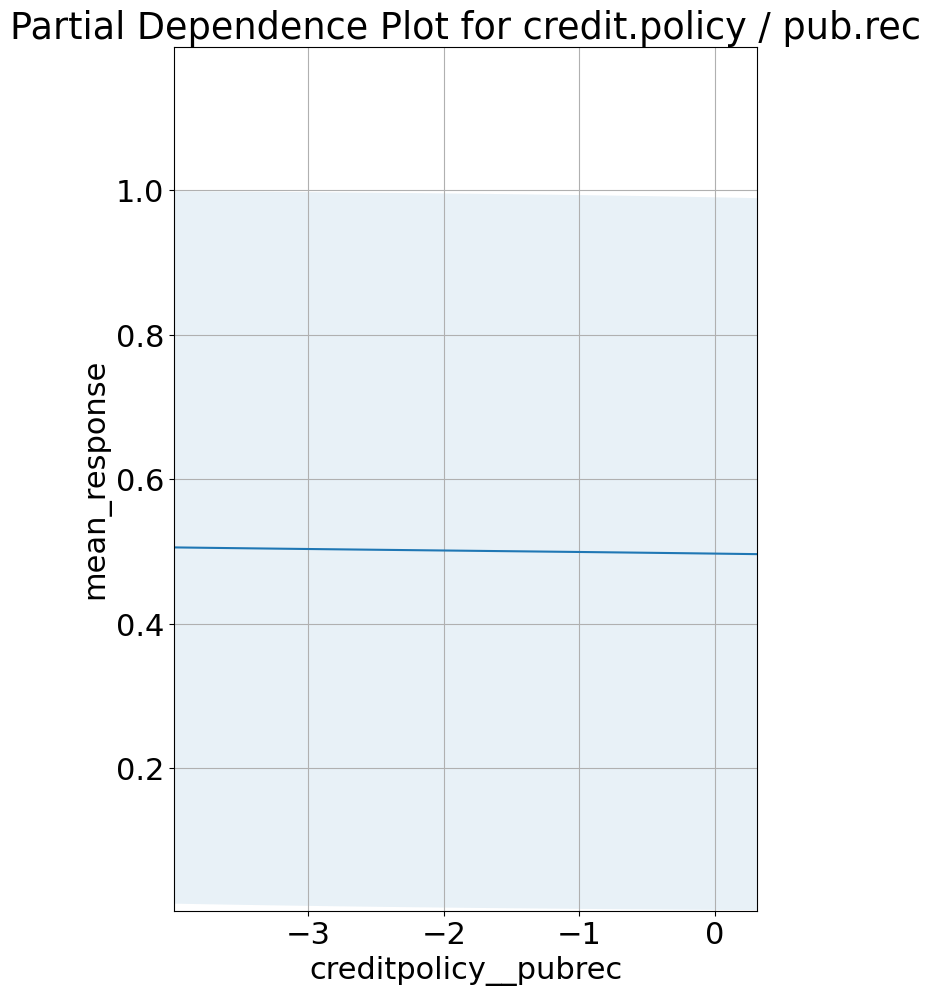

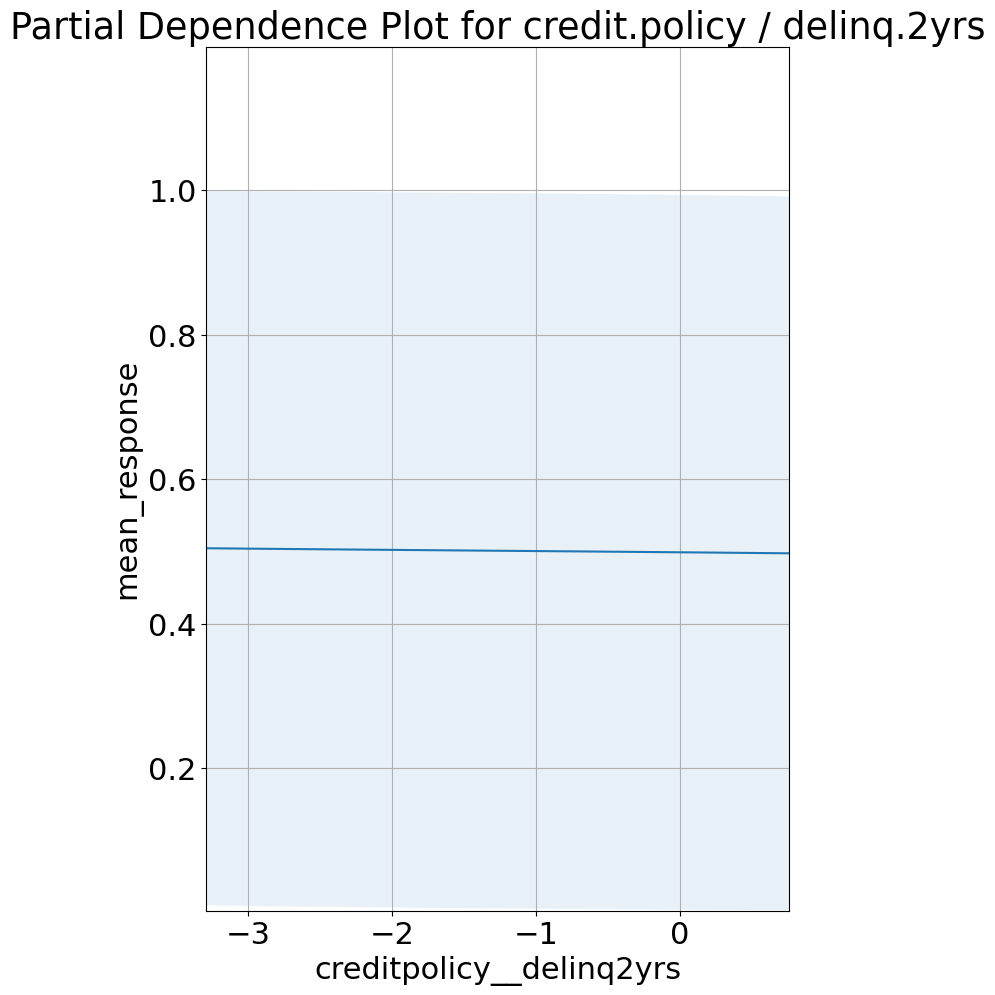

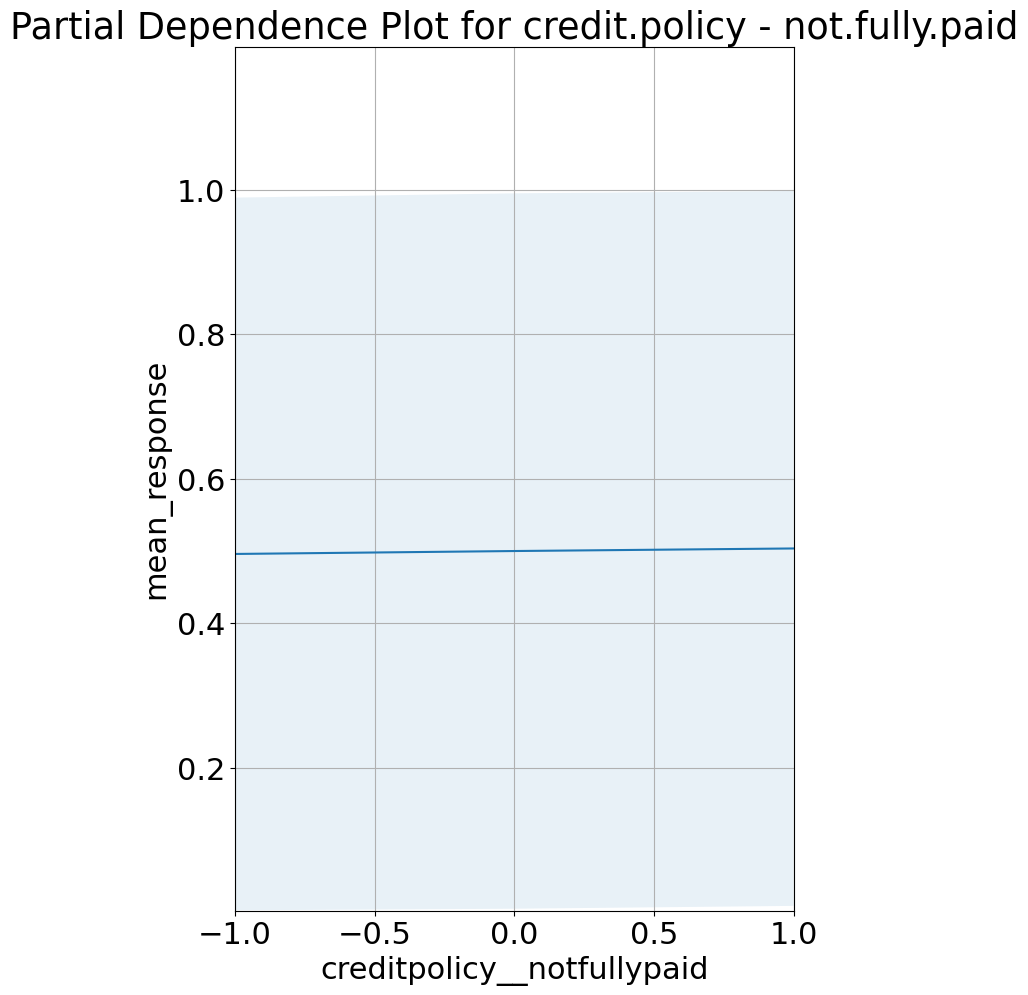

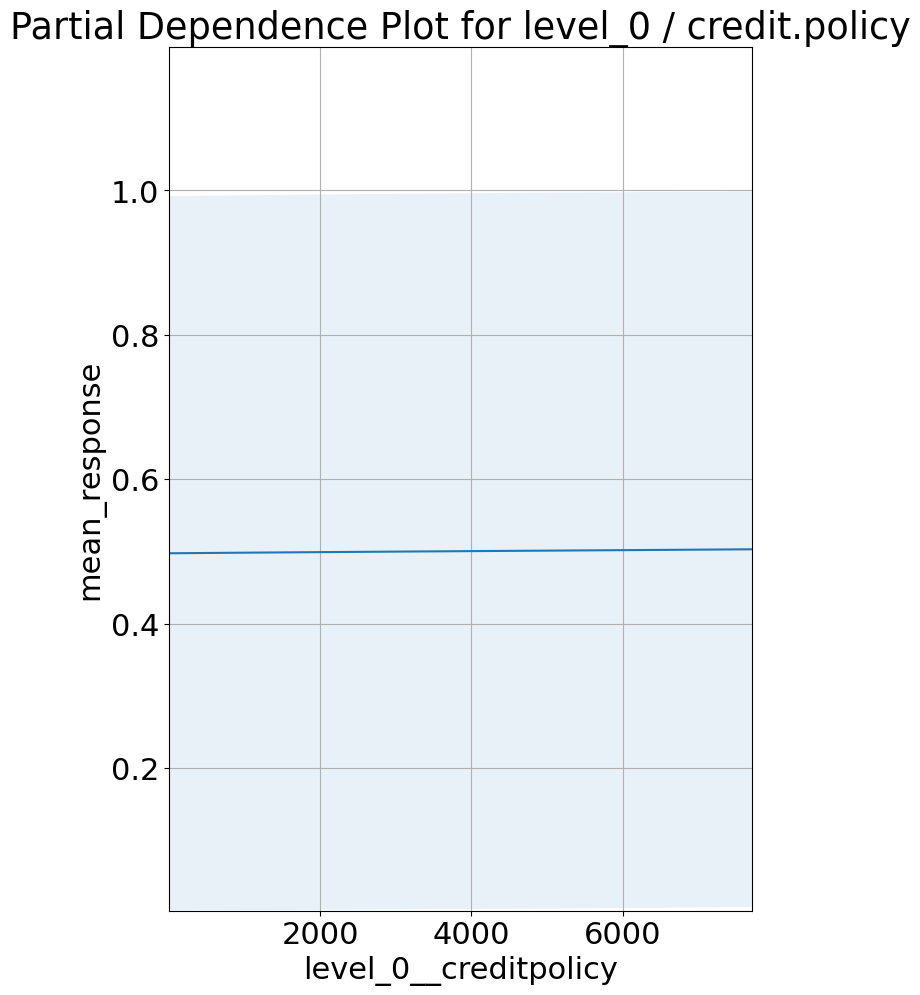

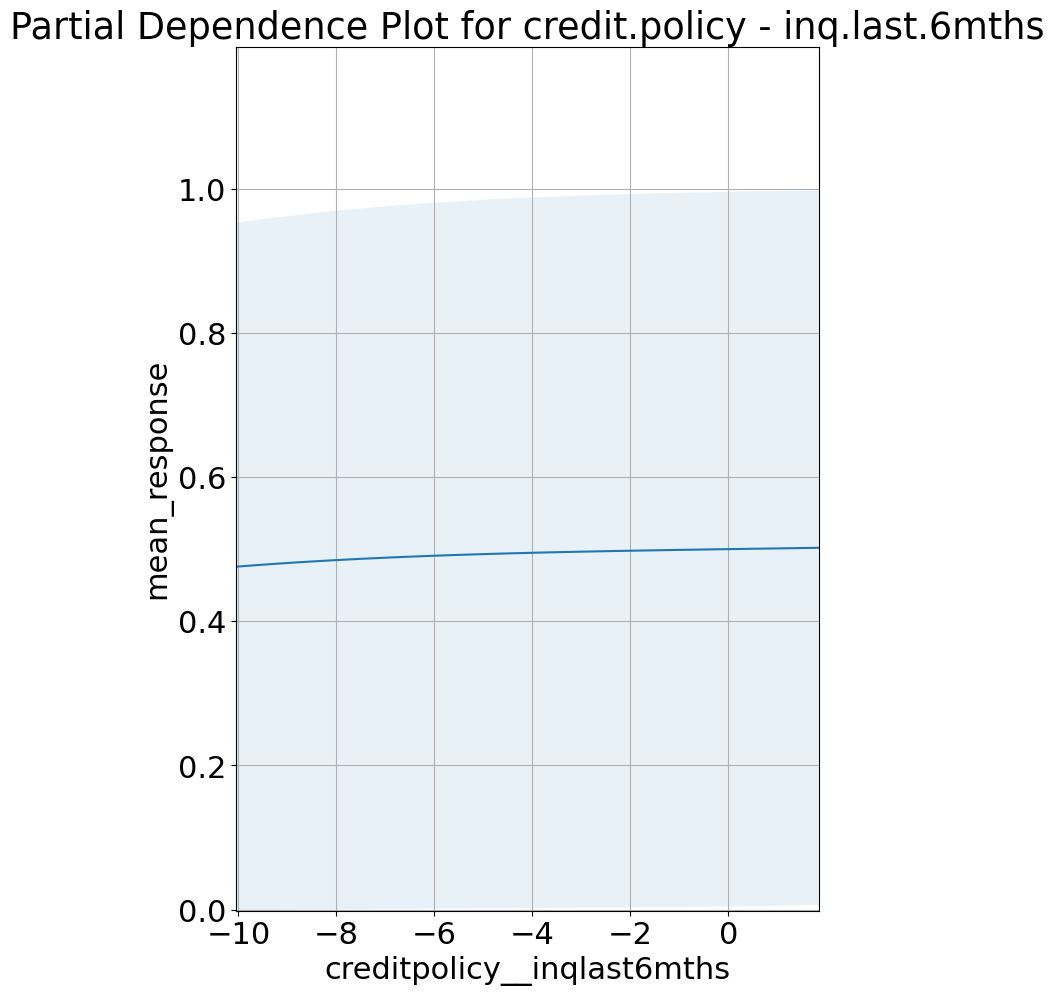

In [35]:
glm_model = [model for model in automl.leaderboard.as_data_frame()["model_id"] if "GLM" in model][0]
best_model = h2o.get_model(glm_model)

# Compute variable importance for each feature
var_importance = best_model.varimp()

# Convert the list to a pandas DataFrame with correct column names
var_importance_df = pd.DataFrame(var_importance, columns=['variable', 'importance','std_dev', 'percentile'])

# Get the top 5 influential features
top_features = var_importance_df.sort_values(by='importance', ascending=False).head(5)['variable']

# Generate partial dependence plots for the top 5 influential features
for feature in top_features:
    best_model.partial_plot(data=train, cols=[feature], plot=True)

In [18]:
# # Get the ROC curve data
# roc_data = performance.roc(best_model)

# # Plot the ROC curve
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# plt.plot(roc_data[0], roc_data[1])
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.show()